In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lab1

In [2]:
data = pd.read_csv("hitters.csv")
data.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [4]:
# as always with any dataset check if there are any missing/null values
data.isnull().sum()

Unnamed: 0     0
AtBat          0
Hits           0
HmRun          0
Runs           0
RBI            0
Walks          0
Years          0
CAtBat         0
CHits          0
CHmRun         0
CRuns          0
CRBI           0
CWalks         0
League         0
Division       0
PutOuts        0
Assists        0
Errors         0
Salary        59
NewLeague      0
dtype: int64

In [6]:
# as one can see, Salary has 59 null values, so we have to drop those 59 rows
hitters = data.dropna()
hitters.isnull().sum()

Unnamed: 0    0
AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary        0
NewLeague     0
dtype: int64

In [9]:
# another thing to notice is that there are a few qualitative predictors in the data set. We 
# we have to convert them into numerical data
qual = ["League", "Division", "NewLeague"]
hitters = pd.get_dummies(hitters, columns = qual)
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,632,43,10,475.0,0,1,0,1,0,1
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,880,82,14,480.0,1,0,0,1,1,0
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,200,11,3,500.0,0,1,1,0,0,1
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,805,40,4,91.5,0,1,1,0,0,1
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,282,421,25,750.0,1,0,0,1,1,0


now that we have preprocessed the data to certain extents, it is time to perform various 
subset selection methods on it

# Best subset Selection

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from sklearn import linear_model
from sklearn.model_selection import KFold

In [16]:
def getDifferentModels(k, x, y):
    '''
    We have to fit all the models that contain exactly k predictors out of the total 
    p predictors
    '''
    #PCk: P combination k
    combinations = itertools.combinations(list(x.columns), k) #picking k predictors out of p
    model_list = []
    for combo in combinations:
        x_smf = "+".join(combo)
        f = "Salary ~ {}".format(x_smf)
        #time to fit the model
        model = smf.ols(formula = f, data = pd.concat([x,y], axis = 1)).fit()
        model_list.append((f, model))
    return model_list

def min_rss(statsmodels):
    "Return the model with the lowest RSS"
    return sorted(statsmodels, key = lambda tup: tup[1].ssr)[0]

def max_adjr2(statsmodels):
    "Return model with highest adjusted r^2"
    return sorted(statsmodels, reverse = True, key = lambda tup: tup[1].rsquared_adj)[0]


    

In [17]:
#lets just test it for 2 predictors right now
x = hitters.drop("Salary", axis = 1)
y = hitters["Salary"]

#get all the possible models
subset = getDifferentModels(2, x, y)
print(min_rss(subset))
print(max_adjr2(subset))

('Salary ~ Hits+CRBI', <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c222c4278>)
('Salary ~ Hits+CRBI', <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c222c4278>)


In [20]:
# cant actually run the combinations for all values of k fro 1 to 22 on my laptop as it will
#die :p
x = hitters.loc[:, "AtBat" : "PutOuts"]

models = []
for k in np.arange(len(x.columns)):
    k = k + 1
    subset = getDifferentModels(k, x, y)
    models.append(subset)
    print("done: ", k)

done:  1
done:  2
done:  3
done:  4
done:  5
done:  6
done:  7
done:  8
done:  9
done:  10
done:  11
done:  12
done:  13
done:  14


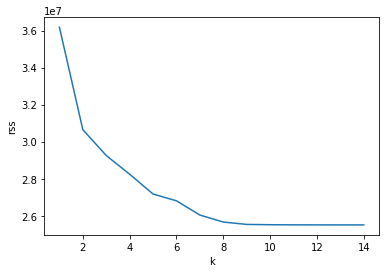

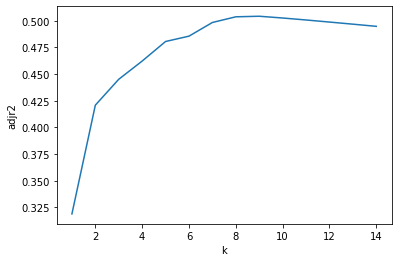

In [24]:
rss = [min_rss(m)[1].ssr for m in models]
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in models]
k = np.arange(1, 1 + len(rss))

ax = sns.lineplot(x = k, y = rss)
plt.xlabel("k")
plt.ylabel("rss")
plt.show()

ax = sns.lineplot(x = k, y = adjr2)
plt.xlabel("k")
plt.ylabel("adjr2")
plt.show()

In [26]:
#now let us look at some individual models
best_subset_6 = list(min_rss(models[5])[1].params.index)[1:]
print(best_subset_6)

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']


# Forward and Backward Selection

In [42]:
def scale(df):
    return (df - df.mean()) / (df.std())

def forwardStepwise(x, y, results = [(0, [])]): #starting from a null model
    p = list(x.columns)
    p_used = results[-1][1]
    p_unused = [i for i in p if i not in p_used]
    
    if not p_unused:
        rss = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({"rss": rss, "predictors": preds}).drop(0).reset_index()
    
    r = []
    for i in p_unused:
        f = "Salary ~ {}".format("+".join([i] + p_used))
        #time to fit the model
        model = smf.ols(formula = f, data = pd.concat([x,y], axis = 1)).fit()
        r.append((model.ssr, [i]+p_used))
    #time to choose the predictor which results in the lowest ssr
    min_rss = sorted(r, key=lambda tup:tup[0])[0]
    new_results = results + [min_rss]
    #recursive call
    return forwardStepwise(x,y, new_results)

def backwardStepwise(x, y, results = []): 
    p_all = list(x.columns)
    
    if not results:
        f = "Salary ~ {}".format("+".join(p_all))
        model = smf.ols(formula = f, data = pd.concat([x,y], axis = 1)).fit()
        return backwardStepwise(x,y, [(model.ssr, p_all)])
    else:
        p_used = results[-1][1]
    
    if len(p_used) == 1:
        rss = [r[0] for r in results]
        preds = [r[1] for r in results] 
        return pd.DataFrame({"rss": rss, "predictors": preds})
    
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f = "Salary ~ {}".format("+".join(p_test))
        model = smf.ols(formula = f, data = pd.concat([x,y], axis = 1)).fit()
        r.append((model.ssr, p_test))
    
    min_rss = sorted(r, key=lambda tup:tup[0])[0]
    new_results = results + [min_rss]
    #recursive call
    return backwardStepwise(x,y, new_results)

In [30]:
x = scale(hitters.loc[:, "AtBat" : "PutOuts"])
backward = backwardStepwise(x,y)

In [34]:
print(backward)

             rss                                         predictors
0   2.550169e+07  [AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...
1   2.550170e+07  [AtBat, Hits, HmRun, Runs, Walks, Years, CAtBa...
2   2.550319e+07  [AtBat, Hits, Runs, Walks, Years, CAtBat, CHit...
3   2.550552e+07  [AtBat, Hits, Runs, Walks, Years, CAtBat, CHmR...
4   2.551233e+07  [AtBat, Hits, Runs, Walks, Years, CAtBat, CRun...
5   2.552857e+07  [AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...
6   2.565678e+07  [AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...
7   2.614246e+07  [AtBat, Hits, Walks, CRuns, CRBI, CWalks, PutO...
8   2.680370e+07       [AtBat, Hits, Walks, CRuns, CWalks, PutOuts]
9   2.750952e+07               [AtBat, Hits, Walks, CRuns, PutOuts]
10  2.845081e+07                      [AtBat, Hits, CRuns, PutOuts]
11  2.940730e+07                             [Hits, CRuns, PutOuts]
12  3.120346e+07                                      [Hits, CRuns]
13  3.643795e+07                                

In [43]:
forward = forwardStepwise(x,y)
print(forward)

    index           rss                                         predictors
0       1  3.617968e+07                                             [CRBI]
1       2  3.064656e+07                                       [Hits, CRBI]
2       3  2.924930e+07                              [PutOuts, Hits, CRBI]
3       4  2.823936e+07                       [AtBat, PutOuts, Hits, CRBI]
4       5  2.717042e+07                [Walks, AtBat, PutOuts, Hits, CRBI]
5       6  2.699220e+07        [CWalks, Walks, AtBat, PutOuts, Hits, CRBI]
6       7  2.614246e+07  [CRuns, CWalks, Walks, AtBat, PutOuts, Hits, C...
7       8  2.565678e+07  [CAtBat, CRuns, CWalks, Walks, AtBat, PutOuts,...
8       9  2.552857e+07  [Runs, CAtBat, CRuns, CWalks, Walks, AtBat, Pu...
9      10  2.551233e+07  [Years, Runs, CAtBat, CRuns, CWalks, Walks, At...
10     11  2.550552e+07  [CHmRun, Years, Runs, CAtBat, CRuns, CWalks, W...
11     12  2.550319e+07  [CHits, CHmRun, Years, Runs, CAtBat, CRuns, CW...
12     13  2.550170e+07  

In [44]:
#let us look at the situation where 6 predictors are in play
print("BestSubSet Selection: " , sorted(best_subset_6))
print("ForwardStepwise Selection: " , sorted(forward.loc[5]['predictors']))
print("BackwardStepwise Selection: " , sorted(backward.loc[8]['predictors']))

BestSubSet Selection:  ['AtBat', 'CRuns', 'CWalks', 'Hits', 'PutOuts', 'Walks']
ForwardStepwise Selection:  ['AtBat', 'CRBI', 'CWalks', 'Hits', 'PutOuts', 'Walks']
BackwardStepwise Selection:  ['AtBat', 'CRuns', 'CWalks', 'Hits', 'PutOuts', 'Walks']


As noticed from the above results, backward selection and best subset have the same results, while forward stepwise has just one different result. Therefore it is safe to say that the backward stepwise selection looks like the best approach as it makes the same optimal selection as best subset selection but with significantly lower computational cost

# Cross-Validation Attempt

In [45]:
def mse(y_hat, y):
    return np.sum(np.square(y_hat - y)) / y.size

In [152]:
def cross_val(formula, x, y, k):
    x_fold = np.array_split(x, k)
    y_fold = np.array_split(y, k)
    
    MSE = []
    for f in np.arange(0, len(x_fold)):
        x_test = x_fold[f]
        y_test = y_fold[f]
        x_train = x.drop(x_fold[f].index)
        y_train = y.drop(y_fold[f].index)
        #fit the model
        #x_train['Salary'] = y_train
        #print(pd.concat([x_train, y_train], axis=1).astype(int).sum())
        #print(pd.concat([x_train, y_train], axis=1).astype(int).info())
        model = smf.ols(formula = formula, data = pd.concat([x_train, y_train], axis=1)).fit()
        y_hat = model.predict(x_test)
        MSE.append(mse(y_hat, y_test))
    return (MSE, formula)



In [ ]:
x = hitters.loc[:, "AtBat" : "PutOuts"]
results = []
for model in models:
    results.append(cross_val(model[0], x, y, 10))

df = pd.DataFrame({"predictors": list(np.arange(1, 15)),
                  "MSE_MEAN" : [np.mean(i[0] for  i in results)],
                  "MSE FOLDS": [i[0] for i in results],
                  "Model": [i[1] for i in results]})

             rss                                         predictors  \
0   2.420070e+07  [Unnamed: 0, AtBat, Hits, HmRun, Runs, RBI, Wa...   
1   2.420070e+07  [Unnamed: 0, AtBat, Hits, HmRun, Runs, RBI, Wa...   
2   2.420070e+07  [AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...   
3   2.420070e+07  [AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...   
4   2.420070e+07  [AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...   
5   2.420184e+07  [AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...   
6   2.420945e+07  [AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...   
7   2.421938e+07  [AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...   
8   2.423518e+07  [AtBat, Hits, HmRun, Runs, Walks, CAtBat, CHit...   
9   2.424866e+07  [AtBat, Hits, HmRun, Runs, Walks, CAtBat, CRun...   
10  2.428915e+07  [AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...   
11  2.433323e+07  [AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...   
12  2.438735e+07  [AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...   
13  2.

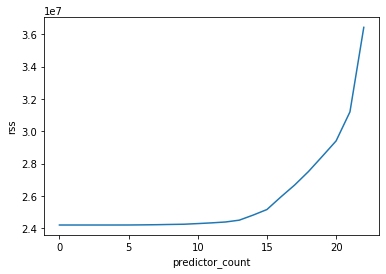

In [150]:
#trying out backward stepwise selection on all the features
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

backward_stepwise_subsets = backwardStepwise(X, y)
backward_stepwise_subsets['predictor_count'] = np.arange(0, 23)
#display(backward_stepwise_subsets)
print(backward_stepwise_subsets)
sns.lineplot(x='predictor_count', y='rss', data=backward_stepwise_subsets)

    predictors       MSE_mean  \
0            1  116599.013674   
1            2  116599.013674   
2            3  116599.013674   
3            4  116599.013674   
4            5  116599.013674   
5            6  114963.338465   
6            7  113635.830694   
7            8  112921.381689   
8            9  111081.510651   
9           10  110333.364753   
10          11  109979.410931   
11          12  109465.608056   
12          13  108361.210922   
13          14  108080.651150   
14          15  106618.881999   
15          16  107458.440564   
16          17  110072.974721   
17          18  111600.002770   
18          19  114825.616417   
19          20  118903.869957   
20          21  121665.135093   
21          22  127363.032055   
22          23  144100.590668   

                                            MSE_folds  \
0   [109666.777009825, 37953.391756388715, 156572....   
1   [109666.77700982467, 37953.39175638833, 156572...   
2   [109666.77700982467, 37953.39175

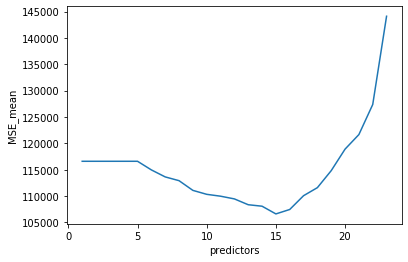

In [153]:
# Perform cross validation for each subset of predictors
results = []
for preds in backward_stepwise_subsets['predictors']:
    f = 'Salary ~ {}'.format(' + '.join(preds))
    results.append(cross_val(f, X.drop("Unnamed: 0", axis = 1), y, 10))

results_b_df = pd.DataFrame({'predictors': list(np.arange(1, len(results)+1)),
                           'MSE_mean': [np.mean(i[0]) for i in results],
                           'MSE_folds': [i[0] for i in results],
                           'Model': [i[1] for i in results]})
print(results_b_df)
sns.lineplot(x='predictors', y='MSE_mean', data=results_b_df)

# Ridge Regression and the Lasso

In [154]:
def ridge_cv(X, y, l , k):
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Ridge(alpha=l, fit_intercept=False, solver='cholesky').fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs.append(mse(y_hat, y_test))
    return MSEs

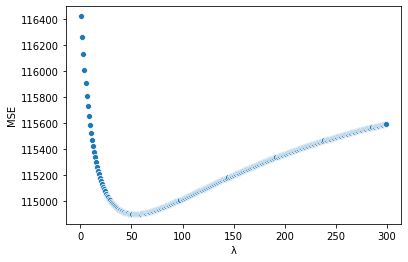

In [156]:
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

lambdas = np.arange(1, 300, 1)
MSEs    = [] 
for l in lambdas:
    MSEs.append(np.mean(ridge_cv(X.drop("Unnamed: 0", axis = 1), y, l, k=10)))

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))

In [157]:
min(zip(MSEs, lambdas))

(114903.19824046257, 53)

        feature  coefficient
0         AtBat    -1.794660
1          Hits     7.288001
2         HmRun     3.626469
3          Runs    -2.356676
4           RBI    -0.843838
5         Walks     6.190308
6         Years     4.445694
7        CAtBat    -0.187145
8         CHits     0.111156
9        CHmRun    -0.206063
10        CRuns     1.511644
11         CRBI     0.795503
12       CWalks    -0.786855
13      PutOuts     0.288676
14      Assists     0.331803
15       Errors    -2.141267
16     League_A    -2.588049
17     League_N    27.207012
18   Division_E    52.645001
19   Division_W   -28.026038
20  NewLeague_A     9.898640
21  NewLeague_N    14.720322


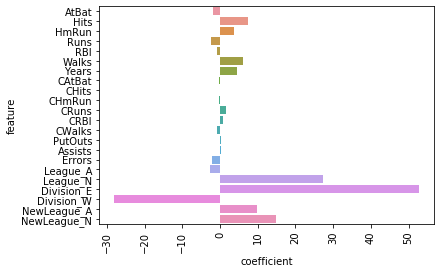

In [160]:
# as it was obvious, we performed k-fold cross validation in order to find the optimum value
# of lambda, the tuning parameter. Why is slecting a good value of lambda important? well
# because each value of lambda will give a different set of coefficients and as lambda approaches
# infinity, the coeffiecients shrink towards zero.

#let us now have a look at the coefficients which ridge regression has chosen for each
#predictor
model = linear_model.Ridge(alpha = 53, fit_intercept = False, solver="cholesky").fit(X.drop("Unnamed: 0", axis = 1), y) 
df = pd.DataFrame({"feature" : X.drop("Unnamed: 0", axis = 1).columns, "coefficient" : model.coef_})
ax = sns.barplot(x = 'coefficient', y = 'feature', data = df)
plt.xticks(rotation = 90)
print(df)

In [161]:
# let us now do a cross validation for finding out the alpha for the lasso
def lasso_cv(x, y, l, k):
    x_folds = np.array_split(x, k)
    y_folds = np.array_split(y, k)
    MSE = []
    for i in np.arange(len(x_folds)):
        x_test = x_folds[i]
        y_test = y_folds[i]
        x_train = x.drop(x_folds[i].index)
        y_train = y.drop(y_folds[i].index)
        model = linear_model.Lasso(alpha = l, copy_X = True, fit_intercept = False,
                                  max_iter = 10000, normalize = False, positive = False,
                                  precompute = False, random_state =None, selection = 'cyclic',
                                  tol = 0.0001, warm_start = False).fit(x_train, y_train)
        y_hat = model.predict(x_test)
        MSE.append(mse(y_hat, y_test))
    return MSE

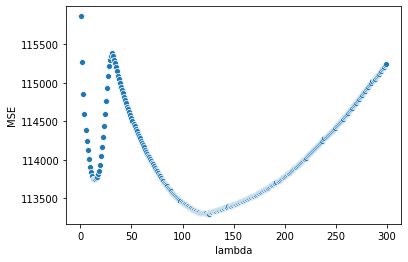

In [163]:
lambdas = np.arange(1,300,1)
MSE = []
for l in lambdas:
    MSE.append(np.mean(lasso_cv(X.drop("Unnamed: 0", axis = 1), y, l, k = 10)))

sns.scatterplot(x = "lambda", y = "MSE", data = pd.DataFrame({"lambda": lambdas, "MSE": MSE}))

In [165]:
min(zip(MSE, lambdas))

(113299.42601088567, 126)

        feature  coefficient
0         AtBat    -1.275521
1          Hits     5.018893
2         HmRun     0.000000
3          Runs    -0.000000
4           RBI     0.000000
5         Walks     4.513408
6         Years     0.000000
7        CAtBat    -0.205982
8         CHits     0.350804
9        CHmRun     0.000000
10        CRuns     1.119450
11         CRBI     0.687998
12       CWalks    -0.513003
13      PutOuts     0.293758
14      Assists     0.223030
15       Errors    -0.000000
16     League_A    -0.000000
17     League_N     0.000000
18   Division_E     0.000000
19   Division_W    -0.000000
20  NewLeague_A    -0.000000
21  NewLeague_N     0.000000


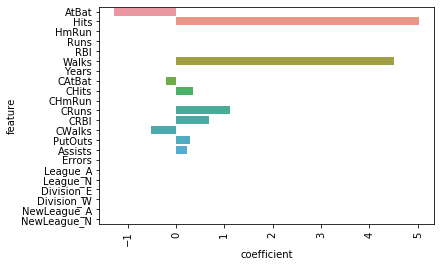

In [166]:
#similar to last time, let us look at how the coefficients have been estimated by the
#lasso
model = linear_model.Lasso(alpha=126, copy_X=True, fit_intercept=False, max_iter=10000,
                           normalize=False, positive=False, precompute=False, random_state=None,
                           selection='cyclic', tol=0.0001, warm_start=False).fit(X.drop("Unnamed: 0", axis = 1), y)
df = pd.DataFrame({'feature' : X.drop("Unnamed: 0", axis = 1).columns, "coefficient" : model.coef_})
ax = sns.barplot(x = "coefficient", y = "feature", data = df)
plt.xticks(rotation = 90)
print(df)

As you can see the one advantage of the Lasso over ridge regression is that it performs variable selection